In [42]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from sklearn.model_selection  import train_test_split
from sklearn.metrics import r2_score 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import  RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


In [2]:
df = pd.read_csv("../../data/eventData.csv")
df.head()

,segmentsTimeStamps,buffering,SegmentStart,SegmentEnd,timeStamp,bitrateNewTrack,bitrateOldTrack,streamBandwidth,estimatedBandwidth,segmentsContentType,bandwidthSpeeds,decodedFrame,droppedFrame
0,252.4,1,-0.003,0.997,2024-08-27T09:56:59.410Z,4844528,0,4844528,5.017675e+07,audio,0,4,0
1,258.0,0,0.000,1.000,2024-08-27T09:57:03.790Z,4844528,0,4844528,7.110392e+07,video,0,11,0
2,277.6,0,0.997,1.997,2024-08-27T09:57:04.064Z,4844528,0,4844528,7.110392e+07,audio,0,19,0
3,283.9,0,1.000,2.000,2024-08-27T09:57:04.328Z,4844528,0,4844528,7.110392e+07,video,0,27,0
4,290.3,0,1.997,2.997,2024-08-27T09:57:04.590Z,4844528,0,4844528,7.110392e+07,audio,0,35,0


In [96]:
# df['timeStamp'] = pd.to_datetime(df['timeStamp'])
# df_chg= df.set_index(['timeStamp'], drop=True)
# plt.figure(figsize=(15,8))
# df_chg['estimatedBandwidth'].plot();


In [104]:
windows_len = 5

In [108]:
split_date = pd.Timestamp('2024-08-27 09:59:30.154000+00:00')
df1 = df['estimatedBandwidth'] 
train = df1.loc[100:]
test = df1.loc[:100]

0      5.017675e+07
1      7.110392e+07
2      7.110392e+07
3      7.110392e+07
4      7.110392e+07
           ...     
96     8.607006e+07
97     8.607006e+07
98     8.607006e+07
99     8.493507e+07
100    8.493507e+07
Name: estimatedBandwidth, Length: 101, dtype: float64

In [106]:
def data_to_input_and_output(data):
    data = pd.DataFrame(data)
    input_data = []
    output_data = []
    
    for index in range(len(data) - windows_len):
        input_sample = data["estimatedBandwidth"][index:index + windows_len]
        output_sample = data["estimatedBandwidth"][index + windows_len]
        
        input_data.append(input_sample)
        output_data.append(output_sample)
    return np.array(input_data),np.array(output_data)



In [107]:
train_input, train_output = data_to_input_and_output(train)
test_input , test_output = data_to_input_and_output(test)

print("We have", len(train_input), "train values")
print("We have", len(test_input), "test values")

KeyError: 5

In [64]:
train_processed = df_chg.iloc[:, 0:1].values
train_processed = train_processed[0:700]
test_processed = df_chg.iloc[:, 0:1].values
test_processed = test_processed[0:800:1]

print(f"test_processed {test_processed.shape} \n")
print(f"train_processed {train_processed.shape} \n")

test_processed (800, 1) 

train_processed (700, 1) 



In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train_processed)
test_sc = scaler.transform(test_processed)

In [66]:
X_train = train_sc[:-1]
y_train = train_sc[1:]
X_test = test_sc[:-1]
y_test = test_sc[1:]

print(X_test.shape)

(799, 1)


In [67]:
def train_neural_network(X,y,epotch=5, learning_rate=0.005):
    model = Sequential()
    model.add(InputLayer((windows_len,1)))
    model.add(LSTM(64))
    model.add(Dense(8,"relu"))
    model.add(Dense(1,"linear"))
    
    checkPoint = ModelCheckpoint("./model.keras",save_best_only=True,monitor="loss")
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate),metrics=[RootMeanSquaredError()])
    model.fit(X, y, epochs=epotch,callbacks=[checkPoint])

In [86]:
# train_neural_network(X_train,y_train)
X_train

array([[-1.        ],
       [-0.99996813],
       [-0.99985658],
       [-0.99982073],
       [-0.9997843 ],
       [-0.97492697],
       [-0.96908839],
       [-0.96908213],
       [-0.96321624],
       [-0.9632077 ],
       [-0.95729571],
       [-0.95729002],
       [-0.95141844],
       [-0.95141502],
       [-0.94554515],
       [-0.9455423 ],
       [-0.93968552],
       [-0.93967926],
       [-0.93385946],
       [-0.9338532 ],
       [-0.92790194],
       [-0.92789682],
       [-0.92204686],
       [-0.92204345],
       [-0.91904989],
       [-0.91904363],
       [-0.91310148],
       [-0.9130918 ],
       [-0.90705745],
       [-0.9070455 ],
       [-0.90116766],
       [-0.90116254],
       [-0.89519648],
       [-0.8951868 ],
       [-0.88930839],
       [-0.88930213],
       [-0.88345559],
       [-0.88344876],
       [-0.87754132],
       [-0.87753506],
       [-0.87159803],
       [-0.87159177],
       [-0.86561433],
       [-0.86560978],
       [-0.85960331],
       [-0

In [73]:
model = load_model("./model.keras")

In [85]:
train_pred = model.predict(X_test)
# test_pred = model.predict(test_input)
# score = r2_score(test_pred,)
train_pred

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[-9.78194535e-01],
       [-9.78175700e-01],
       [-9.78109181e-01],
       [-9.78087962e-01],
       [-9.78066266e-01],
       [-9.62474287e-01],
       [-9.58265841e-01],
       [-9.58261430e-01],
       [-9.54032481e-01],
       [-9.54026163e-01],
       [-9.49762642e-01],
       [-9.49758589e-01],
       [-9.44936693e-01],
       [-9.44933355e-01],
       [-9.39238489e-01],
       [-9.39235747e-01],
       [-9.33551133e-01],
       [-9.33545172e-01],
       [-9.27893817e-01],
       [-9.27887738e-01],
       [-9.22106087e-01],
       [-9.22101200e-01],
       [-9.16415513e-01],
       [-9.16412175e-01],
       [-9.13501799e-01],
       [-9.13495600e-01],
       [-9.07716453e-01],
       [-9.07707036e-01],
       [-9.01835740e-01],
       [-9.01823997e-01],
       [-8.96102309e-01],
       [-8.96097362e-01],
       [-8.90287161e-01],
       [-8.90277743e-01],
       [-8.84550512e-01],
       [-8.84544373e-01],
       [-8.78845811e-01],
       [-8.78839016e-01],
       [-8.7

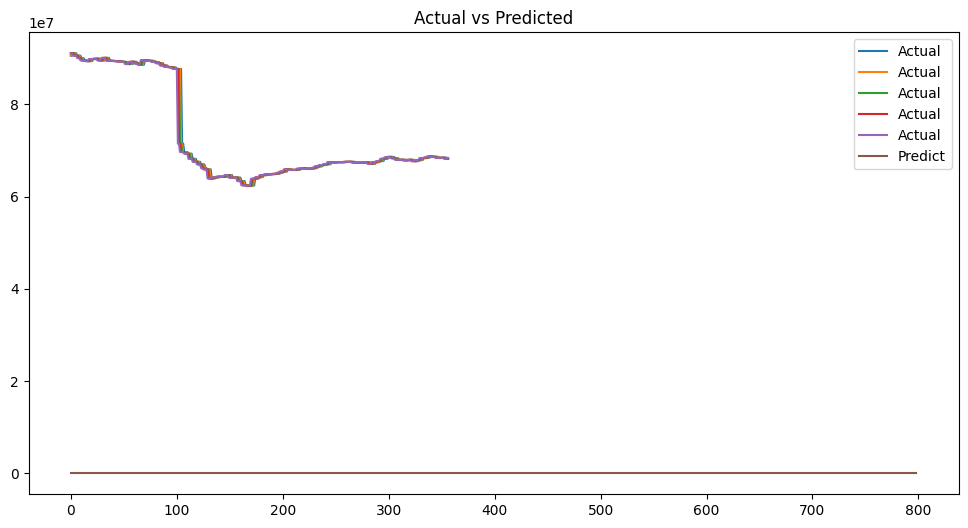

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(test_input, label='Actual')
plt.plot(test_pred, label='Predict')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()
